# TCGA RNA-seq classifier

Load TCGA RNA-seq expression, train/test split with stratification, train a Logistic Regression classifier, and visualize structure with PCA (plus t-SNE for a nonlinear view). The dataset here has multiple cancer types (BRCA, KIRC, LUAD, PRAD, COAD); if you work with a binary subtype setting (e.g., Subtype A vs B), map the labels to two classes before running the same cells.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
RANDOM_STATE = 42


In [2]:
# Paths (fallback to label.csv if labels.csv is absent)
data_path = Path("data.csv")
labels_path = Path("labels.csv")
if not labels_path.exists():
    labels_path = Path("label.csv")

# Load and align samples by index
X_df = pd.read_csv(data_path, index_col=0)
y_df = pd.read_csv(labels_path, index_col=0)

label_col = "Class" if "Class" in y_df.columns else y_df.columns[0]
y = y_df[label_col]
X = X_df.loc[y.index]  # align expression rows to label order

print(f"Features shape: {X.shape}")
print(f"Label distribution:{y.value_counts()}")
assert len(X) == len(y), "Mismatch between samples in expression matrix and labels"


Features shape: (801, 20531)
Label distribution:Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train label proportions:\n", y_train.value_counts(normalize=True))
print("Test label proportions:\n", y_test.value_counts(normalize=True))


Train shape: (600, 20531), Test shape: (201, 20531)
Train label proportions:
 Class
BRCA    0.375000
KIRC    0.181667
LUAD    0.176667
PRAD    0.170000
COAD    0.096667
Name: proportion, dtype: float64
Test label proportions:
 Class
BRCA    0.373134
KIRC    0.184080
LUAD    0.174129
PRAD    0.169154
COAD    0.099502
Name: proportion, dtype: float64


In [4]:
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=2000))
])
clf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression(max_iter=2000))])

In [5]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")


Test accuracy: 0.9900


Explained variance ratio (PC1, PC2): [0.10539781 0.08754232]
Total variance in first 2 PCs: 0.19294013819924105


C:\Users\Atopos.N\AppData\Local\Temp\ipykernel_11776\1706809503.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(classes))


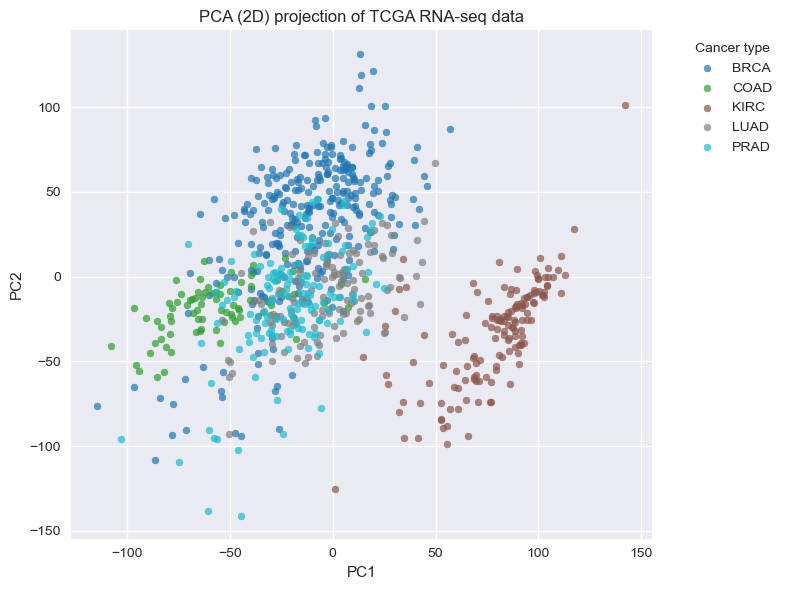

In [6]:
# PCA (2D) on standardized full dataset
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_scaled)
print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_)
print("Total variance in first 2 PCs:", pca2.explained_variance_ratio_.sum())

classes = np.unique(y)
cmap = plt.cm.get_cmap("tab10", len(classes))

fig, ax = plt.subplots(figsize=(8, 6))
for idx, cls in enumerate(classes):
    mask = (y == cls).values
    ax.scatter(X_pca2[mask, 0], X_pca2[mask, 1],
               label=cls, color=cmap(idx), alpha=0.7, s=25)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA (2D) projection of TCGA RNA-seq data")
ax.legend(title="Cancer type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


There is overlap in 2D PCA visualization, so linearly divisible is not supported in 2D; However, the accuracy of the full-dimensional LogisticRegression test ≈ 0.99, indicating that it may can be divided at the high-dimensional linear boundary.

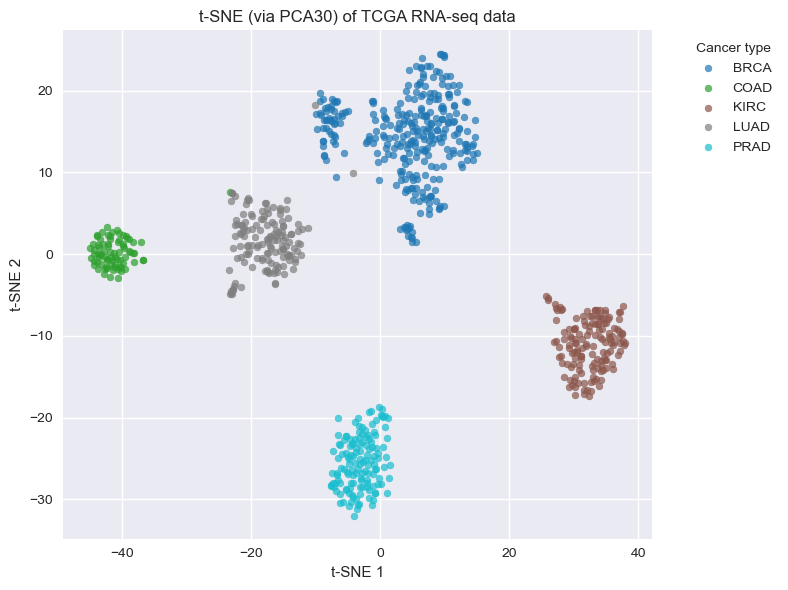

In [7]:
# Nonlinear view: t-SNE on PCA-reduced data (50 -> 2 dims)
pca50 = PCA(n_components=30, random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(X_scaled)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=40, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_pca50)

fig, ax = plt.subplots(figsize=(8, 6))
for idx, cls in enumerate(classes):
    mask = (y == cls).values
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               label=cls, color=cmap(idx), alpha=0.7, s=25)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE (via PCA30) of TCGA RNA-seq data")
ax.legend(title="Cancer type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [8]:
# Simple clustering check (KMeans on PCA30)
n_clusters = len(classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
km_labels = kmeans.fit_predict(X_pca50)
ari = adjusted_rand_score(y, km_labels)
print(f"Adjusted Rand Index (cluster vs true labels): {ari:.3f}")

Adjusted Rand Index (cluster vs true labels): 0.815


KMeans (k=5 on PCA30) yielded an ARI ≈0.815, indicating that the unsupervised cluster was highly consistent with the real label but not perfect.